# Congress Sentiment Analysis and Emotion Detection on Twitter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# uncomment lines if running notebook for the first time
#nltk.download("stopwords")
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from textblob.classifiers import NaiveBayesClassifier
from textblob import TextBlob

import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Project description

The data for this project is taken from two different sources:
 - [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp): dataset for modeling emotions
 - The second dataset I scraped from twitter. It has 5000 tweets mentioning congress, and the tweets are not retweets or quote tweets. The file for this data is called ScrapeTwitterData.ipynb and the csv file is called tweets_including_congress.csv. The model built from the kaggle data will be used to model emotions on the twitter data, and I will also apply sentiment analysis using the Textblob library.
 
The purpose of this project is to take a look at how people are feeling about congress. Recently there have been a lot of controversial decisions made by parts of the United States government, and there have also been many senseless tragedies. Because of this, I am expecting to uncover many tweets expressing emotions like anger or sadness. I will be testing a range of models either using the default parameters or using GridSearchCV to explore using different parameters to determine the best model to predict emotions from text. At the end I will visualize some of the insights gathered and look at how people are really feeling about the government.    

## Emotion Detector

In [2]:
train = pd.read_csv("train_emotion.txt", sep=";", header=None).rename(columns={0:"sentence", 1:"emotion"})
test = pd.read_csv("test_emotion.txt", sep=";", header=None).rename(columns={0:"sentence", 1:"emotion"})
val = pd.read_csv("val_emotion.txt", sep=";", header=None).rename(columns={0:"sentence", 1:"emotion"})

# I will only use a train a testing set, and use cross validation on the training set
test_full = pd.concat([test, val])

### Clean data

In [3]:
def clean_strings(data, stem_type="Stem"):
    stem_type_list = ["Stem", "Lem"]
    assert stem_type in stem_type_list, 'stem_type must be Stem or Lem, case sensitive. Stem uses PorterStemmer and Lem used WordNetLemmatizer'
        
    data["sentence"] = data["sentence"].apply(lambda x: " ".join(x.lower() for x in x.split()))
    data["sentence"] = data["sentence"].apply(lambda x: " ".join(re.sub(r"[^\w\s]", "", x) for x in x.split()))
    data["sentence"] = data["sentence"].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords.words("english")))
    
    if stem_type == "Stem":
        st = PorterStemmer()
        data["sentence"] =  data["sentence"].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    else:
        lem = WordNetLemmatizer()
        data["sentence"] =  data["sentence"].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))
    return data

In [4]:
train_clean = clean_strings(train)
test_full_clean = clean_strings(test_full)

### Check for class label differences in training and testing sets

In [5]:
print(f"Training data emotion counts:\n{train_clean['emotion'].value_counts()}\n")
print(f"Testing data emotion counts:\n{test_full_clean['emotion'].value_counts()}")

Training data emotion counts:
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

Testing data emotion counts:
joy         1399
sadness     1131
anger        550
fear         436
love         337
surprise     147
Name: emotion, dtype: int64


### Label Encoding Dependent Variable

In [6]:
le = LabelEncoder()

train_clean["emotion"] = le.fit_transform(train_clean["emotion"])
test_full_clean["emotion"] = le.fit_transform(test_full_clean["emotion"])

In [7]:
print(f"Training data emotion counts after LabelEncoder:\n{train_clean['emotion'].value_counts()}\n")
print(f"Testing data emotion counts after LabelEncoder:\n{test_full_clean['emotion'].value_counts()}")

Training data emotion counts after LabelEncoder:
2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: emotion, dtype: int64

Testing data emotion counts after LabelEncoder:
2    1399
4    1131
0     550
1     436
3     337
5     147
Name: emotion, dtype: int64


There is a lot of class imbalance in this dataset when looking at the dependent variable. Because of this, accuracy will not be the primary metric I will be looking at to determine the optimal model. I will instead be primarily using the f1-score and the confusion matrix as a guide to determining the best model.

## Build a model to Predict Emotion from Text

In [8]:
tf_idf = TfidfVectorizer()

tf_idf_train = tf_idf.fit_transform(train_clean["sentence"])
tf_idf_test = tf_idf.transform(test_full_clean["sentence"])

In [9]:
def build_model(model_type, Xdata_train, ydata_train, Xdata_test, ydata_test, need_tune=False, param_grid=None):
    if need_tune == False:
        model_fit = model_type.fit(Xdata_train, ydata_train)
        y_predict = model_fit.predict(Xdata_test)
        
        cm = confusion_matrix(ydata_test, y_predict)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        print(f"""Classification Report:\n{classification_report(ydata_test, y_predict)}\n
        Accuracy Score: {accuracy_score(ydata_test, y_predict)}\n
        Confusion Matrix:\n{disp.plot()}
        """)
        
    if need_tune == True:
        clf = GridSearchCV(model_type, param_grid)
        clf.fit(Xdata_train, ydata_train)
        print("The best estimator across ALL searched params:\n", clf.best_params_)
        
        y_predict = clf.predict(Xdata_test)
        
        cm = confusion_matrix(ydata_test, y_predict)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        print(f"""Classification Report:\n{classification_report(ydata_test, y_predict)}\n
        Accuracy Score: {accuracy_score(ydata_test, y_predict)}\n
        Confusion Matrix:\n{disp.plot()}
        """)

Logistic Regression Model Evalutation
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       550
           1       0.84      0.78      0.81       436
           2       0.83      0.93      0.88      1399
           3       0.81      0.56      0.66       337
           4       0.86      0.91      0.88      1131
           5       0.85      0.54      0.66       147

    accuracy                           0.84      4000
   macro avg       0.84      0.75      0.79      4000
weighted avg       0.84      0.84      0.84      4000


        Accuracy Score: 0.84175

        Confusion Matrix:
        


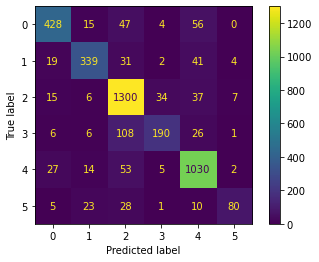

In [10]:
print("Logistic Regression Model Evalutation")
build_model(model_type=LogisticRegression(max_iter=500, random_state=0), Xdata_train=tf_idf_train, ydata_train=train_clean["emotion"], Xdata_test=tf_idf_test, 
                 ydata_test=test_full_clean["emotion"])

Multinomial Naive Bayes Model Evalutation
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.33      0.49       550
           1       0.93      0.30      0.45       436
           2       0.64      0.97      0.77      1399
           3       1.00      0.08      0.15       337
           4       0.68      0.90      0.77      1131
           5       0.00      0.00      0.00       147

    accuracy                           0.68      4000
   macro avg       0.70      0.43      0.44      4000
weighted avg       0.73      0.68      0.62      4000


        Accuracy Score: 0.68025

        Confusion Matrix:
        


C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


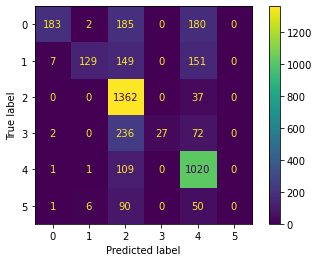

In [11]:
print("Multinomial Naive Bayes Model Evalutation")
build_model(model_type=MultinomialNB(), Xdata_train=tf_idf_train, ydata_train=train_clean["emotion"], Xdata_test=tf_idf_test, 
                 ydata_test=test_full_clean["emotion"])

The Multinomial Naive Bayes Model does not predict anything as class 5 (surprise), so I will automatically eliminate considering using this model going forward.

KNN Model Evalutation
The best estimator across ALL searched params:
 {'n_neighbors': 9, 'p': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       550
           1       0.78      0.71      0.74       436
           2       0.79      0.88      0.83      1399
           3       0.76      0.48      0.59       337
           4       0.82      0.84      0.83      1131
           5       0.73      0.44      0.55       147

    accuracy                           0.79      4000
   macro avg       0.77      0.69      0.72      4000
weighted avg       0.79      0.79      0.78      4000


        Accuracy Score: 0.788

        Confusion Matrix:
        


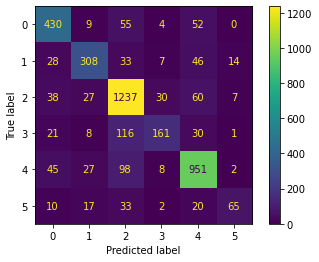

In [12]:
print("KNN Model Evalutation")
build_model(KNeighborsClassifier(), Xdata_train=tf_idf_train, ydata_train=train_clean["emotion"], Xdata_test=tf_idf_test, 
                 ydata_test=test_full_clean["emotion"], need_tune=True, param_grid={"n_neighbors": [i for i in range(5,10)], "p": [1, 2]})

SVM Model Evalutation
The best estimator across ALL searched params:
 {'C': 2, 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       550
           1       0.81      0.79      0.80       436
           2       0.83      0.91      0.87      1399
           3       0.79      0.61      0.69       337
           4       0.88      0.89      0.89      1131
           5       0.78      0.63      0.70       147

    accuracy                           0.84      4000
   macro avg       0.82      0.77      0.79      4000
weighted avg       0.84      0.84      0.84      4000


        Accuracy Score: 0.84125

        Confusion Matrix:
        


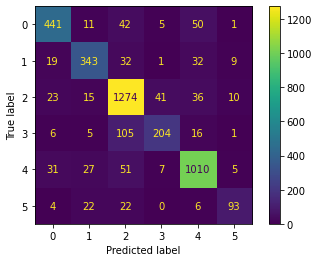

In [13]:
print("SVM Model Evalutation")
build_model(SVC(random_state=0), Xdata_train=tf_idf_train, ydata_train=train_clean["emotion"], Xdata_test=tf_idf_test, 
                 ydata_test=test_full_clean["emotion"], need_tune=True, param_grid={"C": [.1, 1, 2],
                                                                                   "kernel": ["poly", "rbf"]})

Random Forest Model Evalutation
The best estimator across ALL searched params:
 {'n_estimators': 500}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       550
           1       0.78      0.84      0.81       436
           2       0.89      0.89      0.89      1399
           3       0.80      0.69      0.74       337
           4       0.91      0.89      0.90      1131
           5       0.68      0.70      0.69       147

    accuracy                           0.86      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.86      0.86      0.86      4000


        Accuracy Score: 0.8585

        Confusion Matrix:
        


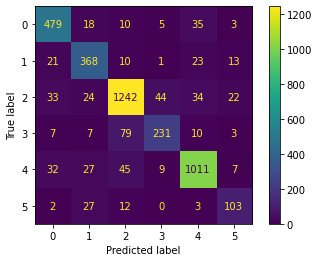

In [14]:
print("Random Forest Model Evalutation")
build_model(RandomForestClassifier(random_state=0), Xdata_train=tf_idf_train, ydata_train=train_clean["emotion"], Xdata_test=tf_idf_test, 
                 ydata_test=test_full_clean["emotion"], need_tune=True, param_grid={"n_estimators": [250, 500, 1000]})

The Random Forest model has the best performance out of all the models tested. Especially when looking at the classes with the least amount of observations. Because of this I will move forward with the Random Forest model and retrain using the optimal parameters discovered from cross validation and grid search.

In [15]:
classifier = RandomForestClassifier(n_estimators=500, random_state=0).fit(tf_idf_train, train_clean["emotion"])

y_preds = classifier.predict(tf_idf_test)

# Take another look at classification report
print(classification_report(test_full_clean["emotion"], y_preds))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       550
           1       0.78      0.84      0.81       436
           2       0.89      0.89      0.89      1399
           3       0.80      0.69      0.74       337
           4       0.91      0.89      0.90      1131
           5       0.68      0.70      0.69       147

    accuracy                           0.86      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.86      0.86      0.86      4000



## Get from Twitter

In [16]:
tweets_df = pd.read_csv("tweets_including_congress.csv")
display(tweets_df.head())

,tweet_created,tweet_id,tweet_content
0,2022-05-25 20:34:10+00:00,1529561486422589440,"@JoeMyGod Yes, given the way this country and ..."
1,2022-05-25 20:34:09+00:00,1529561482408493056,@MrsRobPope @davidhogg111 You had a super majo...
2,2022-05-25 20:34:09+00:00,1529561482131906562,@CNYCentral Some in Congress will and the rest...
3,2022-05-25 20:34:06+00:00,1529561467338604552,"In other words, only a very vocal minority of ..."
4,2022-05-25 20:34:05+00:00,1529561464972910594,The House will vote on a so-called red flag gu...


In [17]:
tweets_df["sentence_porter"] = clean_strings(tweets_df.rename(columns={"tweet_content":"sentence"}), stem_type="Stem")["sentence"]
tweets_df["sentence_lemmatizer"] = clean_strings(tweets_df.rename(columns={"tweet_content":"sentence"}), stem_type="Lem")["sentence"]

### Transform Data using tf_idf and Predict Emotion

In [18]:
tweets_tfidf = tf_idf.transform(tweets_df["sentence_porter"])

tweets_df["Emotion"] = classifier.predict(tweets_tfidf)
display(tweets_df.head())

,tweet_created,tweet_id,tweet_content,sentence_porter,sentence_lemmatizer,Emotion
0,2022-05-25 20:34:10+00:00,1529561486422589440,"@JoeMyGod Yes, given the way this country and ...",joemygod ye given way countri politician activ...,joemygod yes given way country politician acti...,0
1,2022-05-25 20:34:09+00:00,1529561482408493056,@MrsRobPope @davidhogg111 You had a super majo...,mrsrobpop davidhogg111 super major congress didnt,mrsrobpope davidhogg111 super majority congres...,2
2,2022-05-25 20:34:09+00:00,1529561482131906562,@CNYCentral Some in Congress will and the rest...,cnycentr congress rest work thought prayer,cnycentral congress rest work thought prayer,0
3,2022-05-25 20:34:06+00:00,1529561467338604552,"In other words, only a very vocal minority of ...",word vocal minor republican hand gun mental bo...,word vocal minority republican hand gun mental...,0
4,2022-05-25 20:34:05+00:00,1529561464972910594,The House will vote on a so-called red flag gu...,hous vote socal red flag gun bill lawmak retur...,house vote socalled red flag gun bill lawmaker...,0


### Label Emotion and Perform Sentiment Analysis

In [19]:
tweets_df["Emotion_Label"] = np.where(tweets_df["Emotion"] == 0, "anger",
                                             np.where(tweets_df["Emotion"] == 1, "fear",
                                                     np.where(tweets_df["Emotion"] == 2, "joy",
                                                              np.where(tweets_df["Emotion"] == 3, "love",
                                                                       np.where(tweets_df["Emotion"] == 4, "sadness",
                                                                                np.where(tweets_df["Emotion"] == 5, "surprise", "Null"))))))

In [20]:
tweets_df["Polarity"] = tweets_df["sentence_lemmatizer"].apply(lambda x: TextBlob(x).sentiment[0])
tweets_df["Subjectivity"] = tweets_df["sentence_lemmatizer"].apply(lambda x: TextBlob(x).sentiment[1])

tweets_df["Polarity_Label"] = np.where(tweets_df["Polarity"] < 0, "Negative",
                                                np.where(tweets_df["Polarity"] > 0, "Positive", "Neutral"))
tweets_df["Subjectivity_Label"] = np.where(tweets_df["Subjectivity"] < .5, "More Objective", "More Subjective")

## Visualizations

In [21]:
sns.set_style("white")
plt.rcParams.update({'font.size': 14})

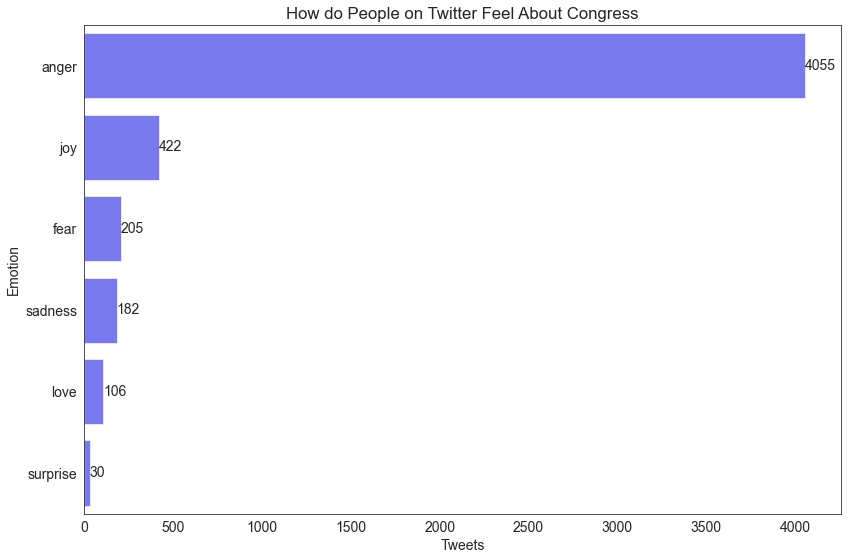

In [22]:
emotion_counts = pd.DataFrame(tweets_df["Emotion_Label"].value_counts()).reset_index().rename(columns={"index":"Emotion", "Emotion_Label":"Count"})

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="Count", y="Emotion", data=emotion_counts,
            label="Total", color="b", alpha=.6)

ax.bar_label(ax.containers[0])

plt.title("How do People on Twitter Feel About Congress")
plt.xlabel("Tweets")
fig.tight_layout()

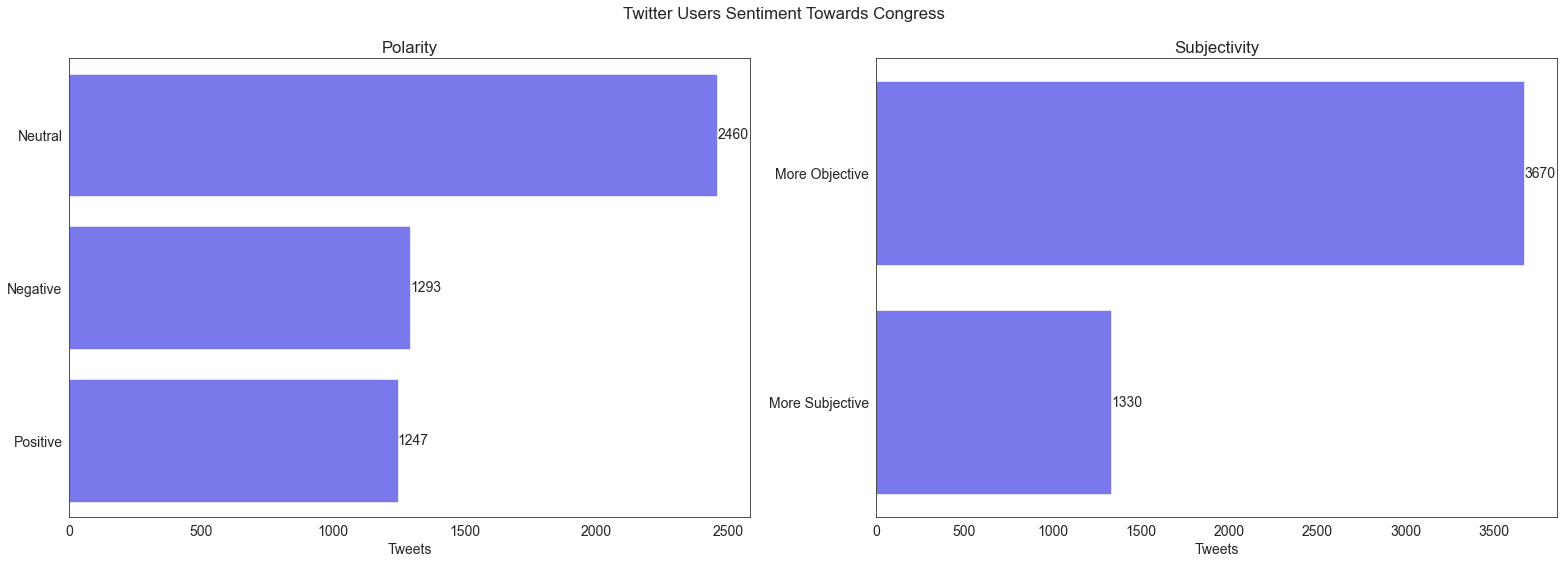

In [23]:
polarity_counts = pd.DataFrame(tweets_df["Polarity_Label"].value_counts()).reset_index().rename(columns={"index":"Polarity", "Polarity_Label":"Count"})
subjectivity_counts = pd.DataFrame(tweets_df["Subjectivity_Label"].value_counts()).reset_index().rename(columns={"index":"Subjectivity", "Subjectivity_Label":"Count"})

fig, ax = plt.subplots(1, 2, figsize=(22, 8))
sns.barplot(x="Count", y="Polarity", data=polarity_counts,
            label="Total", color="b", alpha=.6, ax=ax[0])
sns.barplot(x="Count", y="Subjectivity", data=subjectivity_counts,
            label="Total", color="b", alpha=.6, ax=ax[1])

ax[0].set_title("Polarity")
ax[0].bar_label(ax[0].containers[0])

ax[1].set_title("Subjectivity")
ax[1].bar_label(ax[1].containers[0])

fig.suptitle("Twitter Users Sentiment Towards Congress")

for i in ax:
    i.set_xlabel("Tweets")
    i.set_ylabel(None)
fig.tight_layout()

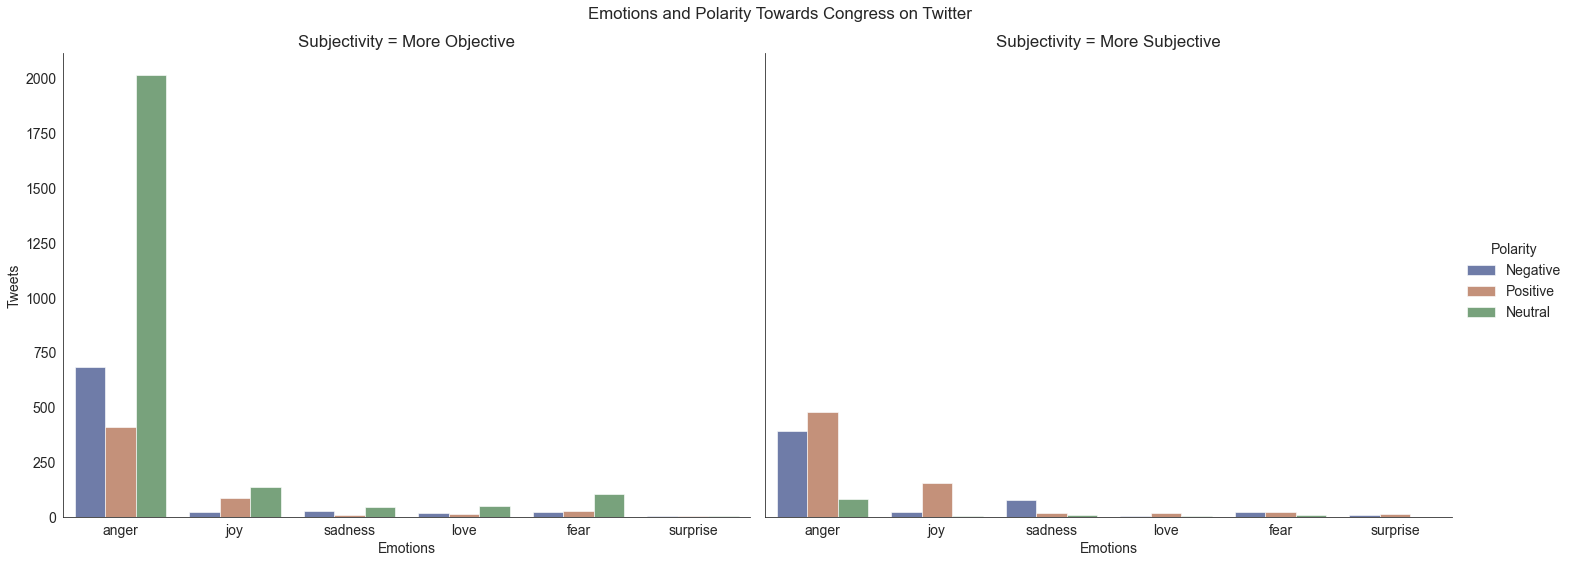

In [24]:
rp = sns.catplot(x="Emotion_Label", hue="Polarity_Label", col="Subjectivity_Label", data=tweets_df, kind="count", palette="dark", alpha=.6, height=8, aspect=9/7,
           col_order=["More Objective", "More Subjective"], legend=False)

#plt.title("Emotions and Polarity Towards Congress on Twitter")
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Emotions and Polarity Towards Congress on Twitter')
rp.axes[0,0].set_xlabel("Emotions")
rp.axes[0,1].set_xlabel("Emotions")
rp.axes[0,0].set_ylabel("Tweets")


rp.axes[0,0].set_title("Subjectivity = More Objective")
rp.axes[0,1].set_title("Subjectivity = More Subjective")

hue_labels = ["Negative", "Positive", "Neutral"]
rp.add_legend(title="Polarity", legend_data={
    key: value for key, value in zip(hue_labels, rp._legend_data.values())
})